# Distance Metric Analysis: Hamming vs Edit Distance for CRISPR Spacer Detection

## Overview

This notebook quantifies how distance metric choice affects false positive rates using simulated CRISPR spacer data with ground truth. We compare:
- **Hamming Distance** (≤5): Substitutions only, ungapped alignment
- **Edit Distance** (≤5): Substitutions + indels, gapped alignment

## tl;dr Key finding:
Hamming distance ≤3 achieves >99% recall with <<1% false positive rate, for any more or using while edit distance we can still achieve >99% recall, but the false positive rate at <=3 is ~4% , and for <=5 it can reach over 50%.  
While the search space size does seem to matter (more contigs and spacers lead to very slightly higher false positive rates), the variation due to distance metric choice is still much larger.

In [3]:
# %load_ext autoreload
# %autoreload 2
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

os.chdir('/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/')

import polars as pl
import matplotlib.pyplot as plt
# import numpy as np
from tqdm import tqdm

from bench.utils.functions import (
    read_fasta, parse_sassy, populate_pldf_withseqs_needletail,
    calculate_hamming_distance, calculate_edit_distance
)

# Configuration
MAX_HAMMING = 5
MAX_EDIT = 5

def load_simulation_data(sim_prefix):
    """Load data for a specific simulation hash."""
    SIMULATED_DIR = f"results/simulated/{sim_prefix}"
    SIMULATED_DATA_DIR = f"{SIMULATED_DIR}/simulated_data"
    SIMULATED_RAW_OUTPUTS = f"{SIMULATED_DIR}/raw_outputs"
    
    ground_truth_file = f"{SIMULATED_DATA_DIR}/planned_ground_truth.tsv"
    spacers_file = f"{SIMULATED_DATA_DIR}/simulated_spacers.fa"
    contigs_file = f"{SIMULATED_DATA_DIR}/simulated_contigs.fa"
    sassy_file = f"{SIMULATED_RAW_OUTPUTS}/sassy.tsv"
    
    # Load data
    ground_truth = pl.read_csv(ground_truth_file, separator="\t")
    spacers = read_fasta(spacers_file)
    contigs = read_fasta(contigs_file)
    sassy_results = parse_sassy(sassy_file, max_mismatches=MAX_EDIT,max_gaps=2).collect()
    
    return {
        'ground_truth': ground_truth,
        'spacers': spacers,
        'contigs': contigs,
        'sassy_results': sassy_results,
        'sim_prefix': sim_prefix,
        'plots_dir': f"{SIMULATED_DIR}/plots"
    }

def calculate_distances_for_alignments(data):
    """Calculate hamming and edit distances for SASSY alignments."""
    print("Recalculating distances...")
    
    # Get unique regions and load sequences
    unique_regions = data['sassy_results'].select(["spacer_id", "contig_id", "strand", "start", "end"]).unique()
    
    spacer_df = pl.DataFrame({
        "spacer_id": list(data['spacers'].keys()),
        "spacer_seq": list(data['spacers'].values())
    })
    unique_regions = unique_regions.join(spacer_df, on='spacer_id', how='left')
    
    unique_regions = populate_pldf_withseqs_needletail(
        seqfile=f"results/simulated/{data['sim_prefix']}/simulated_data/simulated_contigs.fa",
        pldf=unique_regions,
        trim_to_region=True,
        reverse_by_strand_col=True,
        chunk_size=200000,
        idcol="contig_id",
        start_col="start",
        end_col="end",
        strand_col="strand",
        seqcol="contig_seq"
    )
    
    # Calculate distances
    distances = []
    for row in tqdm(unique_regions.iter_rows(named=True), total=unique_regions.height, desc="Calculating"):
        if row['spacer_seq'] is None or row['contig_seq'] is None:
            continue
        hamming = calculate_hamming_distance(row['spacer_seq'], row['contig_seq'])
        edit = calculate_edit_distance(row['spacer_seq'], row['contig_seq'], gap_open=10, gap_extend=5)
        distances.append({
            'spacer_id': row['spacer_id'],
            'contig_id': row['contig_id'],
            'strand': row['strand'],
            'start': row['start'],
            'end': row['end'],
            'hamming_distance': hamming,
            'edit_distance': edit,
        })
    
    distances_df = pl.DataFrame(distances)
    sassy_with_dist = data['sassy_results'].join(distances_df, on=['spacer_id', 'contig_id', 'strand', 'start', 'end'], how='left')
    
    print(f"✓ {distances_df.height:,} alignments recalculated")
    return distances_df, sassy_with_dist

def analyze_distance_metrics(data, distances_df, sassy_with_dist, hamming_thresholds=None, edit_thresholds=None):
    """Analyze performance metrics for different distance thresholds."""
    if hamming_thresholds is None:
        hamming_thresholds = [0, 1, 2, 3, 4, 5]
    if edit_thresholds is None:
        edit_thresholds = [0, 1, 2, 3, 4, 5]
    
    # Join GT with distances
    gt_with_distances = data['ground_truth'].join(
        distances_df, 
        on=['spacer_id', 'contig_id', 'strand', 'start', 'end'], 
        how='left'
    )
    
    print(f"Ground truth: {data['ground_truth'].height:,} entries")
    print(f"SASSY results: {sassy_with_dist.height:,} alignments")
    print(f"Analyzing hamming thresholds: {hamming_thresholds}")
    print(f"Analyzing edit thresholds: {edit_thresholds}")
    
    # Hamming analysis
    hamming_results = []
    for threshold in hamming_thresholds:
        filtered_gt = gt_with_distances.filter(pl.col('hamming_distance') <= threshold)
        gt_set = set((row['spacer_id'], row['contig_id'], row['strand']) for row in filtered_gt.iter_rows(named=True))
        
        tp = fp = fn = 0
        for row in sassy_with_dist.iter_rows(named=True):
            key = (row['spacer_id'], row['contig_id'], row['strand'])
            in_gt = key in gt_set
            meets_threshold = row['hamming_distance'] <= threshold
            
            if in_gt and meets_threshold:
                tp += 1
            elif not in_gt and meets_threshold:
                fp += 1
            elif in_gt and not meets_threshold:
                fn += 1
        
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        pct_identified = recall * 100
        pct_missed = (1 - recall) * 100 if (tp + fn) > 0 else 0
        pct_false = (fp / (tp + fp)) * 100 if (tp + fp) > 0 else 0
        
        hamming_results.append({
            'Threshold': threshold,
            'TP': tp,
            'FP': fp,
            'FN': fn,
            'Identified %': f'{pct_identified:.2f}%',
            'Missed %': f'{pct_missed:.2f}%',
            'False %': f'{pct_false:.2f}%',
            'Precision': f'{precision:.2%}',
            'Recall': f'{recall:.2%}',
        })
    
    # Edit analysis
    edit_results = []
    for threshold in edit_thresholds:
        filtered_gt = gt_with_distances.filter(pl.col('edit_distance') <= threshold)
        gt_set = set((row['spacer_id'], row['contig_id'], row['strand']) for row in filtered_gt.iter_rows(named=True))
        
        tp = fp = fn = 0
        for row in sassy_with_dist.iter_rows(named=True):
            key = (row['spacer_id'], row['contig_id'], row['strand'])
            in_gt = key in gt_set
            meets_threshold = row['edit_distance'] <= threshold
            
            if in_gt and meets_threshold:
                tp += 1
            elif not in_gt and meets_threshold:
                fp += 1
            elif in_gt and not meets_threshold:
                fn += 1
        
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        pct_identified = recall * 100
        pct_missed = (1 - recall) * 100 if (tp + fn) > 0 else 0
        pct_false = (fp / (tp + fp)) * 100 if (tp + fp) > 0 else 0
        
        edit_results.append({
            'Threshold': threshold,
            'TP': tp,
            'FP': fp,
            'FN': fn,
            'Identified %': f'{pct_identified:.2f}%',
            'Missed %': f'{pct_missed:.2f}%',
            'False %': f'{pct_false:.2f}%',
            'Precision': f'{precision:.2%}',
            'Recall': f'{recall:.2%}',
        })
    
    return pl.DataFrame(hamming_results), pl.DataFrame(edit_results)

def plot_threshold_analysis(hamming_df, edit_df, sim_prefix, plots_dir):
    """Create comparison plots for distance threshold analysis."""
    # Convert results to numeric for plotting
    hamming_numeric = hamming_df.with_columns([
        pl.col('Identified %').str.strip_chars('%').cast(pl.Float64),
        pl.col('Missed %').str.strip_chars('%').cast(pl.Float64),
        pl.col('False %').str.strip_chars('%').cast(pl.Float64),
    ])
    
    edit_numeric = edit_df.with_columns([
        pl.col('Identified %').str.strip_chars('%').cast(pl.Float64),
        pl.col('Missed %').str.strip_chars('%').cast(pl.Float64),
        pl.col('False %').str.strip_chars('%').cast(pl.Float64),
    ])
    
    # Create comparison plots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
    
    # Hamming: Identified vs Missed
    ax1.plot(hamming_numeric['Threshold'], hamming_numeric['Identified %'], 'o-', linewidth=2, markersize=8, label='Identified', color="#16e46c")
    ax1.plot(hamming_numeric['Threshold'], hamming_numeric['Missed %'], 's-', linewidth=2, markersize=8, label='Missed', color="#ff1900")
    ax1.set_xlabel('Threshold', fontweight='bold')
    ax1.set_ylabel('Percentage (%)', fontweight='bold')
    ax1.set_title(f'Hamming Distance: Identification Rate ({sim_prefix})', fontweight='bold', fontsize=12)
    ax1.set_xticks(hamming_numeric['Threshold'].to_list())
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Hamming: False percentage
    ax2.bar(hamming_numeric['Threshold'], hamming_numeric['False %'], color="#ff0000", alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Threshold', fontweight='bold')
    ax2.set_ylabel('False Positives (%)', fontweight='bold')
    ax2.set_title(f'Hamming Distance: False Positives ({sim_prefix})', fontweight='bold', fontsize=12)
    ax2.set_xticks(hamming_numeric['Threshold'].to_list())
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Edit: Identified vs Missed
    ax3.plot(edit_numeric['Threshold'], edit_numeric['Identified %'], 'o-', linewidth=2, markersize=8, label='Identified', color="#20d76c")
    ax3.plot(edit_numeric['Threshold'], edit_numeric['Missed %'], 's-', linewidth=2, markersize=8, label='Missed', color='#e74c3c')
    ax3.set_xlabel('Threshold', fontweight='bold')
    ax3.set_ylabel('Percentage (%)', fontweight='bold')
    ax3.set_title(f'Edit Distance: Identification Rate ({sim_prefix})', fontweight='bold', fontsize=12)
    ax3.set_xticks(edit_numeric['Threshold'].to_list())
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Edit: False percentage
    ax4.bar(edit_numeric['Threshold'], edit_numeric['False %'], color="#ff0000", alpha=0.7, edgecolor='black')
    ax4.set_xlabel('Threshold', fontweight='bold')
    ax4.set_ylabel('False Positives (%)', fontweight='bold')
    ax4.set_title(f'Edit Distance: False Positives ({sim_prefix})', fontweight='bold', fontsize=12)
    ax4.set_xticks(edit_numeric['Threshold'].to_list())
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    os.makedirs(plots_dir, exist_ok=True)
    plt.savefig(f'{plots_dir}/threshold_analysis_{sim_prefix}.png', dpi=150, bbox_inches='tight')
    plt.show()

print(f"Configuration: Hamming ≤ {MAX_HAMMING}, Edit ≤ {MAX_EDIT}")

Configuration: Hamming ≤ 5, Edit ≤ 5


## Comparison Across Different Search Space Sizes

Now let's compare the performance metrics across different simulation sizes to understand how search space size affects distance metric performance.

All simulations use the same parameters: 25-40 bp spacer length, 10000-150000 bp contig length, 0-5 mismatches.  
EXCEPTION IS ns_1000000_nc_20000_real, STILL RUNNING AND MIGHT NOT FINISH: 
```bash
# real spacers, 20k simulated contigs, 20000 contigs, 1-5 insertions, 25-40 spacer length, 10000-250000 contig length, 0-5 mismatches
pixi run "spacer_bencher simulate --contig-distribution normal --spacers  imgvr4_data/spacers/All_CRISPR_spacers_nr_clean.fna --num-spacers 1000000 --contig-gc-content 46 --spacer-insertions 1 5 --num-contigs 20000  --contig-length 10000 150000 --mismatch-range 0 5 --output-dir ./results/simulated/ns_1000000_nc_20000_real/ --threads 8"
```

In [3]:
import glob 
# Find all simulation folders starting with 'ns_'
simulated_base_dir = "results/simulated"
simulation_dirs = glob.glob(os.path.join(simulated_base_dir, "ns_*"))

def format_num(n):
    if n >= 1000000:
        return f"{n//1000000}M"
    else:
        return f"{n//1000}k"

sim_prefixes = [os.path.basename(p) for p in simulation_dirs]
SIMULATION_NAMES = {h: f"{format_num(int(h.split('_')[1]))} spacers, {format_num(int(h.split('_')[3]))} contigs" for h in sim_prefixes}
SIMULATION_NAMES

{'ns_1000000_nc_20000_real': '1M spacers, 20k contigs',
 'ns_100000_nc_10000': '100k spacers, 10k contigs',
 'ns_100000_nc_20000': '100k spacers, 20k contigs',
 'ns_50000_nc_5000': '50k spacers, 5k contigs',
 'ns_75000_nc_10000': '75k spacers, 10k contigs',
 'ns_75000_nc_5000': '75k spacers, 5k contigs'}

In [ ]:
SIMULATION_NAMES.pop("ns_1000000_nc_20000_real")
SIMULATION_NAMES.pop("ns_1000000_nc_20000_real_baseline")

'1M spacers, 20k contigs'

In [5]:
SIMULATION_NAMES

{'ns_100000_nc_10000': '100k spacers, 10k contigs',
 'ns_100000_nc_20000': '100k spacers, 20k contigs',
 'ns_50000_nc_5000': '50k spacers, 5k contigs',
 'ns_75000_nc_10000': '75k spacers, 10k contigs',
 'ns_75000_nc_5000': '75k spacers, 5k contigs'}

In [5]:
# Compare across different simulation sizes
comparison_results = []
for sim_prefix, description in SIMULATION_NAMES.items():
    print(f"\nProcessing simulation: {sim_prefix} - {description}")
    try:
        # Load data
        data = load_simulation_data(sim_prefix)
        
        # Calculate distances
        distances_df, sassy_with_dist = calculate_distances_for_alignments(data)
        
        # Analyze distance metrics
        hamming_df, edit_df = analyze_distance_metrics(
            data, distances_df, sassy_with_dist, 
            hamming_thresholds=list(range(MAX_HAMMING + 1)), # Hamming thresholds from 0 to MAX_HAMMING
            edit_thresholds=list(range(MAX_EDIT + 1)) # same for edit
        )
        
        comparison_results.append({
            'sim_prefix': sim_prefix,
            'description': description,
            'hamming_df': hamming_df,
            'edit_df': edit_df
        })
    except Exception as e:
        print(f"Error processing {sim_prefix}: {e}")
        continue


Processing simulation: ns_100000_nc_10000 - 100k spacers, 10k contigs

[ThreadControl] Setting environment variables for 10 threads (Sassy)
Starting DuckDB Pipeline (Writing to: results/simulated/ns_100000_nc_10000/raw_outputs/sassy_parsed_20260115.parquet)...
Returning lazy frame (no materialization).
Recalculating distances...
Initial pldf shape: (555007, 6)
Unique entries in minipldf: (555003, 4)
After filtering nulls: (555003, 4)
Actual number of sequences in file: 10000

Processing chunk 10000/10000
Number of sequences in chunk: 10000
Trimming sequences
Reversing sequences
Joining with nascent df
Null count in seqcol after chunk: 0

Final merge with original df
Final null count in seqcol: 0


Calculating: 100%|██████████| 555007/555007 [00:11<00:00, 48278.09it/s]


✓ 555,007 alignments recalculated
Ground truth: 300,219 entries
SASSY results: 555,007 alignments
Analyzing hamming thresholds: [0, 1, 2, 3, 4, 5]
Analyzing edit thresholds: [0, 1, 2, 3, 4, 5]

Processing simulation: ns_100000_nc_20000 - 100k spacers, 20k contigs

[ThreadControl] Setting environment variables for 10 threads (Sassy)
Starting DuckDB Pipeline (Writing to: results/simulated/ns_100000_nc_20000/raw_outputs/sassy_parsed_20260115.parquet)...
Returning lazy frame (no materialization).
Recalculating distances...
Initial pldf shape: (811536, 6)
Unique entries in minipldf: (811531, 4)
After filtering nulls: (811531, 4)
Actual number of sequences in file: 20000

Processing chunk 20000/20000
Number of sequences in chunk: 20000
Trimming sequences
Reversing sequences
Joining with nascent df
Null count in seqcol after chunk: 0

Final merge with original df
Final null count in seqcol: 0


Calculating: 100%|██████████| 811536/811536 [00:16<00:00, 49710.74it/s]


✓ 811,536 alignments recalculated
Ground truth: 299,909 entries
SASSY results: 811,536 alignments
Analyzing hamming thresholds: [0, 1, 2, 3, 4, 5]
Analyzing edit thresholds: [0, 1, 2, 3, 4, 5]

Processing simulation: ns_50000_nc_5000 - 50k spacers, 5k contigs

[ThreadControl] Setting environment variables for 10 threads (Sassy)
Starting DuckDB Pipeline (Writing to: results/simulated/ns_50000_nc_5000/raw_outputs/sassy_parsed_20260115.parquet)...
Returning lazy frame (no materialization).
Recalculating distances...
Initial pldf shape: (214482, 6)
Unique entries in minipldf: (214481, 4)
After filtering nulls: (214481, 4)
Actual number of sequences in file: 5000

Processing chunk 5000/5000
Number of sequences in chunk: 5000
Trimming sequences
Reversing sequences
Joining with nascent df
Null count in seqcol after chunk: 0

Final merge with original df
Final null count in seqcol: 0


Calculating: 100%|██████████| 214482/214482 [00:04<00:00, 46551.64it/s]


✓ 214,482 alignments recalculated
Ground truth: 149,589 entries
SASSY results: 214,482 alignments
Analyzing hamming thresholds: [0, 1, 2, 3, 4, 5]
Analyzing edit thresholds: [0, 1, 2, 3, 4, 5]

Processing simulation: ns_75000_nc_10000 - 75k spacers, 10k contigs

[ThreadControl] Setting environment variables for 10 threads (Sassy)
Starting DuckDB Pipeline (Writing to: results/simulated/ns_75000_nc_10000/raw_outputs/sassy_parsed_20260115.parquet)...
Returning lazy frame (no materialization).
Recalculating distances...
Initial pldf shape: (421843, 6)
Unique entries in minipldf: (421841, 4)
After filtering nulls: (421841, 4)
Actual number of sequences in file: 10000

Processing chunk 10000/10000
Number of sequences in chunk: 10000
Trimming sequences
Reversing sequences
Joining with nascent df
Null count in seqcol after chunk: 0

Final merge with original df
Final null count in seqcol: 0


Calculating: 100%|██████████| 421843/421843 [00:08<00:00, 48184.87it/s]


✓ 421,843 alignments recalculated
Ground truth: 224,557 entries
SASSY results: 421,843 alignments
Analyzing hamming thresholds: [0, 1, 2, 3, 4, 5]
Analyzing edit thresholds: [0, 1, 2, 3, 4, 5]

Processing simulation: ns_75000_nc_5000 - 75k spacers, 5k contigs

[ThreadControl] Setting environment variables for 10 threads (Sassy)
Starting DuckDB Pipeline (Writing to: results/simulated/ns_75000_nc_5000/raw_outputs/sassy_parsed_20260115.parquet)...
Returning lazy frame (no materialization).
Recalculating distances...
Initial pldf shape: (319976, 6)
Unique entries in minipldf: (319975, 4)
After filtering nulls: (319975, 4)
Actual number of sequences in file: 5000

Processing chunk 5000/5000
Number of sequences in chunk: 5000
Trimming sequences
Reversing sequences
Joining with nascent df
Null count in seqcol after chunk: 0

Final merge with original df
Final null count in seqcol: 0


Calculating: 100%|██████████| 319976/319976 [00:06<00:00, 46888.93it/s]


✓ 319,976 alignments recalculated
Ground truth: 225,292 entries
SASSY results: 319,976 alignments
Analyzing hamming thresholds: [0, 1, 2, 3, 4, 5]
Analyzing edit thresholds: [0, 1, 2, 3, 4, 5]


In [6]:
comparison_results

[{'sim_prefix': 'ns_100000_nc_10000',
  'description': '100k spacers, 10k contigs',
  'hamming_df': shape: (6, 9)
  ┌───────────┬────────┬───────┬──────┬──────────────┬──────────┬─────────┬───────────┬────────┐
  │ Threshold ┆ TP     ┆ FP    ┆ FN   ┆ Identified % ┆ Missed % ┆ False % ┆ Precision ┆ Recall │
  │ ---       ┆ ---    ┆ ---   ┆ ---  ┆ ---          ┆ ---      ┆ ---     ┆ ---       ┆ ---    │
  │ i64       ┆ i64    ┆ i64   ┆ i64  ┆ str          ┆ str      ┆ str     ┆ str       ┆ str    │
  ╞═══════════╪════════╪═══════╪══════╪══════════════╪══════════╪═════════╪═══════════╪════════╡
  │ 0         ┆ 49990  ┆ 0     ┆ 32   ┆ 99.94%       ┆ 0.06%    ┆ 0.00%   ┆ 100.00%   ┆ 99.94% │
  │ 1         ┆ 99138  ┆ 0     ┆ 42   ┆ 99.96%       ┆ 0.04%    ┆ 0.00%   ┆ 100.00%   ┆ 99.96% │
  │ 2         ┆ 146754 ┆ 0     ┆ 206  ┆ 99.86%       ┆ 0.14%    ┆ 0.00%   ┆ 100.00%   ┆ 99.86% │
  │ 3         ┆ 193347 ┆ 72    ┆ 558  ┆ 99.71%       ┆ 0.29%    ┆ 0.04%   ┆ 99.96%    ┆ 99.71% │
  │ 4        

In [ ]:
# Create summary comparison plots
def create_comparison_plots(comparison_results, output_dir="results/simulated/plots"):
    """Create summary plots comparing all simulations."""
    import matplotlib.pyplot as plt
    import numpy as np
    # import seaborn as sns
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Prepare data for plotting
    sim_labels = []
    hamming_data = []
    edit_data = []
    
    for results in comparison_results:
        sim_prefix = results['sim_prefix']
        desc = results['description']
        sim_labels.append(f"{sim_prefix}\n{desc}")
        
        # Get data for threshold 3 (common threshold used in analysis)
        hamming_row = results['hamming_df'].filter(pl.col('Threshold') == 3)
        edit_row = results['edit_df'].filter(pl.col('Threshold') == 3)
        
        hamming_data.append({
            'sim': sim_prefix,
            'Identified %': float(hamming_row['Identified %'].to_list()[0].strip('%')),
            'Missed %': float(hamming_row['Missed %'].to_list()[0].strip('%')),
            'False %': float(hamming_row['False %'].to_list()[0].strip('%'))
        })
        
        edit_data.append({
            'sim': sim_prefix,
            'Identified %': float(edit_row['Identified %'].to_list()[0].strip('%')),
            'Missed %': float(edit_row['Missed %'].to_list()[0].strip('%')),
            'False %': float(edit_row['False %'].to_list()[0].strip('%'))
        })
    
    # Create comparison plots
    fig, (ax2, ax4) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Hamming: False %
    false_vals = [d['False %'] for d in hamming_data]
    ax2.bar(range(len(sim_labels)), false_vals, color="#ff1900", alpha=0.7, edgecolor='black')
    ax2.set_title('Hamming Distance (≤3): False Positives', fontweight='bold', fontsize=14)
    ax2.set_ylabel('False Positives (%)', fontweight='bold')
    ax2.set_xticks(range(len(sim_labels)))
    ax2.set_xticklabels(sim_labels, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3, axis='y')
    # Add value labels
    for i, v in enumerate(false_vals):
        ax2.text(i, v , f'{v:.3f}%', ha='center', va='bottom', fontweight='bold')
    
    # Edit: False %
    false_vals = [d['False %'] for d in edit_data]
    ax4.bar(range(len(sim_labels)), false_vals, color="#e74c3c", alpha=0.7, edgecolor='black')
    ax4.set_title('Edit Distance (≤3): False Positives', fontweight='bold', fontsize=14)
    ax4.set_ylabel('False Positives (%)', fontweight='bold')
    ax4.set_xticks(range(len(sim_labels)))
    ax4.set_xticklabels(sim_labels, rotation=45, ha='right')
    ax4.grid(True, alpha=0.3, axis='y')
    # Add value labels
    for i, v in enumerate(false_vals):
        ax4.text(i, v, f'{v:.3f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/simulation_comparison_threshold_3.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Averaged threshold curves across simulations
    if comparison_results:
        fig4, (ax_h, ax_e) = plt.subplots(1, 2, figsize=(14, 6))
        
        thresholds = [0, 1, 2, 3, 4, 5]
        metrics = ['Identified %', 'Missed %', 'False %']
        colors = ['green', 'red', 'orange']
        
        # Hamming
        for metric, color in zip(metrics, colors):
            means = []
            stds = []
            for thresh in thresholds:
                vals = [float(results['hamming_df'].filter(pl.col('Threshold') == thresh)[metric].to_list()[0].strip('%')) for results in comparison_results]
                means.append(np.mean(vals))
                stds.append(np.std(vals))
            ax_h.errorbar(thresholds, means, yerr=stds, label=metric, color=color, capsize=5, marker='o', linewidth=2, markersize=6)
        ax_h.set_xlabel('Threshold', fontweight='bold')
        ax_h.set_ylabel('Percentage (%)', fontweight='bold')
        ax_h.set_title('Hamming Distance: Averaged Across Simulations', fontweight='bold')
        ax_h.legend()
        ax_h.grid(True, alpha=0.3)
        ax_h.set_xticks(thresholds)
        
        # Edit
        for metric, color in zip(metrics, colors):
            means = []
            stds = []
            for thresh in thresholds:
                vals = [float(results['edit_df'].filter(pl.col('Threshold') == thresh)[metric].to_list()[0].strip('%')) for results in comparison_results]
                means.append(np.mean(vals))
                stds.append(np.std(vals))
            ax_e.errorbar(thresholds, means, yerr=stds, label=metric, color=color, capsize=5, marker='o', linewidth=2, markersize=6)
        ax_e.set_xlabel('Threshold', fontweight='bold')
        ax_e.set_ylabel('Percentage (%)', fontweight='bold')
        ax_e.set_title('Edit Distance: Averaged Across Simulations', fontweight='bold')
        ax_e.legend()
        ax_e.grid(True, alpha=0.3)
        ax_e.set_xticks(thresholds)
        
        plt.tight_layout()
        plt.savefig(f'{output_dir}/averaged_threshold_curves.png', dpi=150, bbox_inches='tight')
        plt.show()
    
    # Prepare data
    data_points = []
    for results in comparison_results:
        sim = results['sim_prefix']
        num_spacers = int(sim.split('_')[1])
        num_contigs = int(sim.split('_')[3])
        hamming_row = results['hamming_df'].filter(pl.col('Threshold') == 3)
        edit_row = results['edit_df'].filter(pl.col('Threshold') == 3)
        hamming_ident = float(hamming_row['Identified %'].to_list()[0].strip('%'))
        hamming_false = float(hamming_row['False %'].to_list()[0].strip('%'))
        edit_ident = float(edit_row['Identified %'].to_list()[0].strip('%'))
        edit_false = float(edit_row['False %'].to_list()[0].strip('%'))
        data_points.append({
            'num_spacers': num_spacers,
            'num_contigs': num_contigs,
            'hamming_ident': hamming_ident,
            'hamming_false': hamming_false,
            'edit_ident': edit_ident,
            'edit_false': edit_false,
            'sim': sim
        })
    
    # New plot: False % vs Search Space Size
    fig5, (ax_h_ss, ax_e_ss) = plt.subplots(1, 2, figsize=(14, 6))
    
    search_spaces = [d['num_spacers'] * d['num_contigs'] for d in data_points]
    hamming_false_vals = [d['hamming_false'] for d in data_points]
    edit_false_vals = [d['edit_false'] for d in data_points]
    sim_labels = [d['sim'] for d in data_points]
    
    # Hamming
    ax_h_ss.scatter(search_spaces, hamming_false_vals, color='red', s=100, alpha=0.8, edgecolors='black')
    # Fit line
    if len(search_spaces) > 1:
        coeffs_h = np.polyfit(search_spaces, hamming_false_vals, 1)
        poly_h = np.poly1d(coeffs_h)
        x_fit = np.linspace(min(search_spaces), max(search_spaces), 100)
        ax_h_ss.plot(x_fit, poly_h(x_fit), 'r--', linewidth=2, label=f'Fit: {coeffs_h[0]:.2e}x + {coeffs_h[1]:.2f}')
    ax_h_ss.set_xlabel('Search Space Size (Spacers × Contigs)', fontweight='bold')
    ax_h_ss.set_ylabel('False Positive %', fontweight='bold')
    ax_h_ss.set_title('Hamming Distance (≤3): False % vs Search Space Size', fontweight='bold')
    ax_h_ss.legend()
    ax_h_ss.grid(True, alpha=0.3)
    # Add labels
    for ss, fp, label in zip(search_spaces, hamming_false_vals, sim_labels):
        ax_h_ss.annotate(label, (ss, fp), xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # Edit
    ax_e_ss.scatter(search_spaces, edit_false_vals, color='orange', s=100, alpha=0.8, edgecolors='black')
    # Fit line
    if len(search_spaces) > 1:
        coeffs_e = np.polyfit(search_spaces, edit_false_vals, 1)
        poly_e = np.poly1d(coeffs_e)
        x_fit = np.linspace(min(search_spaces), max(search_spaces), 100)
        ax_e_ss.plot(x_fit, poly_e(x_fit), 'orange', linestyle='--', linewidth=2, label=f'Fit: {coeffs_e[0]:.2e}x + {coeffs_e[1]:.2f}')
    ax_e_ss.set_xlabel('Search Space Size (Spacers × Contigs)', fontweight='bold')
    ax_e_ss.set_ylabel('False Positive %', fontweight='bold')
    ax_e_ss.set_title('Edit Distance (≤3): False % vs Search Space Size', fontweight='bold')
    ax_e_ss.legend()
    ax_e_ss.grid(True, alpha=0.3)
    # Add labels
    for ss, fp, label in zip(search_spaces, edit_false_vals, sim_labels):
        ax_e_ss.annotate(label, (ss, fp), xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/false_positives_vs_search_space.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print summary table
    print("SUMMARY COMPARISON (Threshold = 3)")
    
    summary_data = []
    for results in comparison_results:
        sim_prefix = results['sim_prefix']
        desc = results['description'] # noqa
        hamming_row = results['hamming_df'].filter(pl.col('Threshold') == 3)
        edit_row = results['edit_df'].filter(pl.col('Threshold') == 3)
        
        summary_data.append({
            'Simulation': sim_prefix,
            'Description': results['description'],
            'Hamming Identified %': hamming_row['Identified %'].item(),
            'Hamming False %': hamming_row['False %'].item(),
            'Edit Identified %': edit_row['Identified %'].item(),
            'Edit False %': edit_row['False %'].item()
        })
    
    summary_df = pl.DataFrame(summary_data)
    print(summary_df)

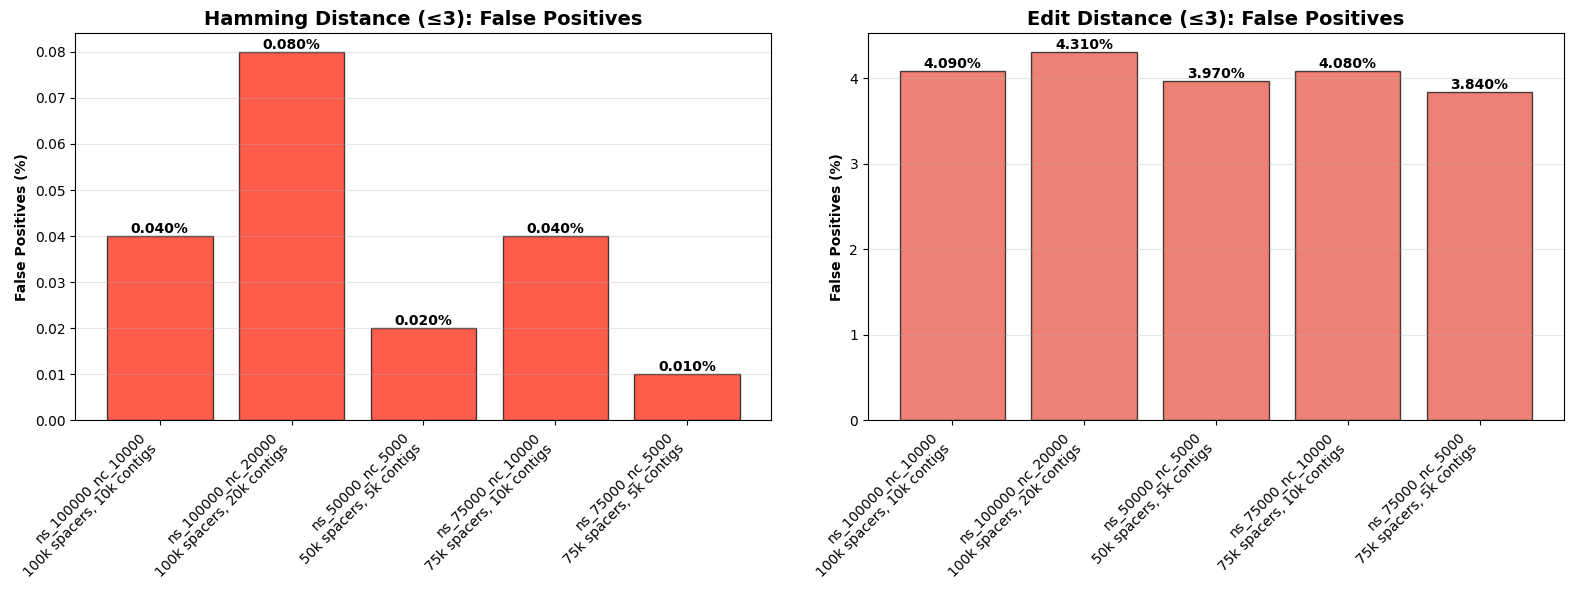

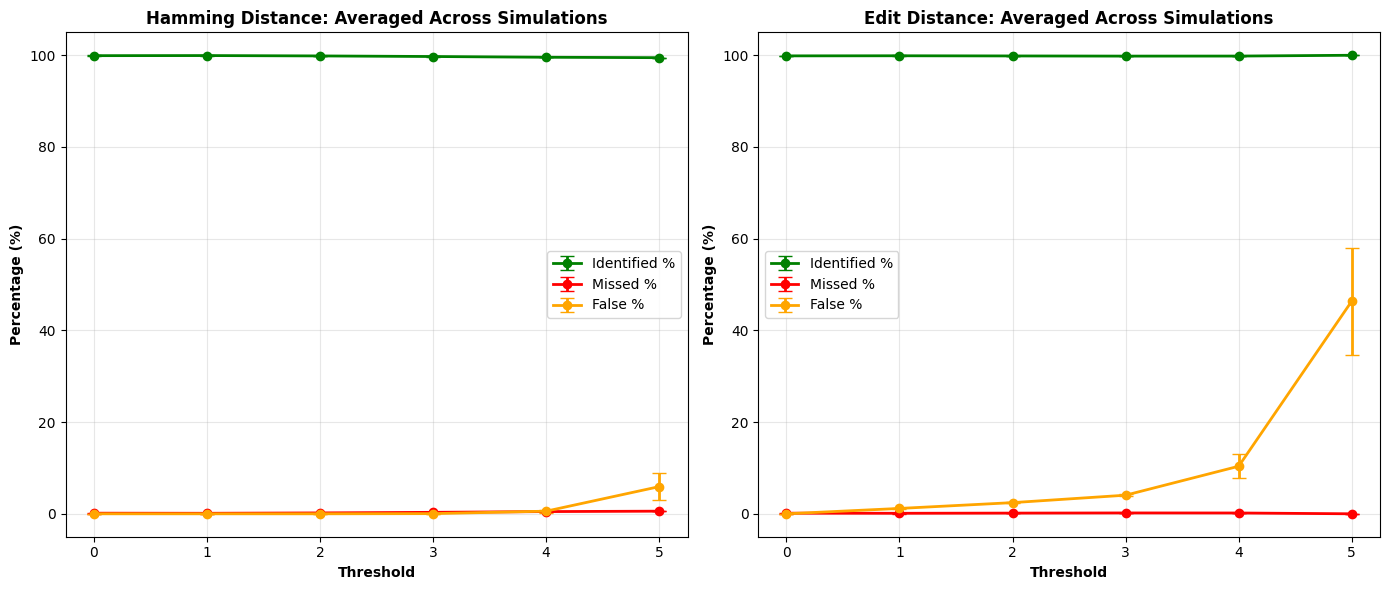

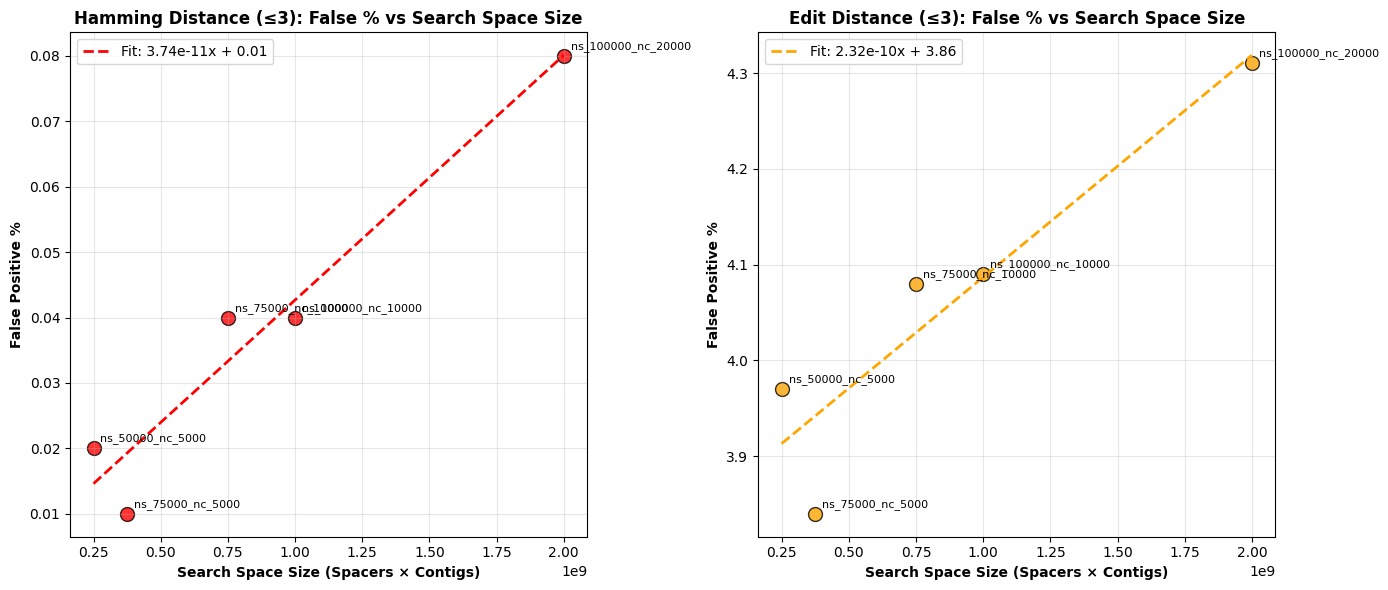

SUMMARY COMPARISON (Threshold = 3)
shape: (5, 6)
┌────────────────────┬───────────────────────────┬──────────────────────┬─────────────────┬───────────────────┬──────────────┐
│ Simulation         ┆ Description               ┆ Hamming Identified % ┆ Hamming False % ┆ Edit Identified % ┆ Edit False % │
│ ---                ┆ ---                       ┆ ---                  ┆ ---             ┆ ---               ┆ ---          │
│ str                ┆ str                       ┆ str                  ┆ str             ┆ str               ┆ str          │
╞════════════════════╪═══════════════════════════╪══════════════════════╪═════════════════╪═══════════════════╪══════════════╡
│ ns_100000_nc_10000 ┆ 100k spacers, 10k contigs ┆ 99.71%               ┆ 0.04%           ┆ 99.84%            ┆ 4.09%        │
│ ns_100000_nc_20000 ┆ 100k spacers, 20k contigs ┆ 99.73%               ┆ 0.08%           ┆ 99.86%            ┆ 4.31%        │
│ ns_50000_nc_5000   ┆ 50k spacers, 5k contigs   ┆ 99.64%     

: 

In [ ]:
# comparison_results
create_comparison_plots(comparison_results)

## Semi synthetic dataset (1M real spacers, 20k simulated contigs)
 real spacers, 20k simulated contigs, 20000 contigs, 1-5 insertions, 25-40 spacer length, 10000-250000 contig length, 0-5 mismatches  
 ````
 pixi run "spacer_bencher simulate --contig-distribution normal --spacers  imgvr4_data/spacers/All_CRISPR_spacers_nr_clean.fna --num-spacers 1000000 --contig-gc-content 46 --spacer-insertions 1 5 --num-contigs 20000  --contig-length 10000 150000 --mismatch-range 0 5 --output-dir ./results/simulated/ns_1000000_nc_20000_real/ --threads 8"
```

In [6]:
# Compare across different simulation sizes
comparison_results_semisyn = []
sim_prefix = "ns_1000000_nc_20000_real"
description = "1M spacers (real), 20k contigs (simulated)"
print(f"\nProcessing simulation: {sim_prefix} - {description}")
# Load data
data = load_simulation_data(sim_prefix)

# Calculate distances
distances_df, sassy_with_dist = calculate_distances_for_alignments(data)

# Analyze distance metrics
hamming_df, edit_df = analyze_distance_metrics(
    data, distances_df, sassy_with_dist, 
    hamming_thresholds=list(range(MAX_HAMMING + 1)), # Hamming thresholds from 0 to MAX_HAMMING
    edit_thresholds=list(range(MAX_EDIT + 1)) # same for edit
)

comparison_results_semisyn.append({
    'sim_prefix': sim_prefix,
    'description': description,
    'hamming_df': hamming_df,
    'edit_df': edit_df
})


Processing simulation: ns_1000000_nc_20000_real - 1M spacers (real), 20k contigs (simulated)
Checking existing cache at: results/simulated/ns_1000000_nc_20000_real/raw_outputs/sassy_parsed_20260115.parquet
>> Valid cache found! Returning lazy frame (no materialization).


: 

OOM...

The sassy output for this is >2tb. So will use the bowtie1 and only do test the hamming distance of <=3 fp%

In [4]:
from bench.utils.functions import parse_sam, read_fasta
spacers_dict = read_fasta("results/simulated/ns_1000000_nc_20000_real/simulated_data/simulated_spacers.fa")
spacer_lendf = pl.DataFrame({
        "spacer_id": spacers_dict.keys(),
        "length": [len(seq) for seq in spacers_dict.values()]
})

bt1_out = "results/simulated/ns_1000000_nc_20000_real/raw_outputs/bowtie1_output.sam"
bt1_df = parse_sam(sam_file=bt1_out,ref_file="results/simulated/ns_1000000_nc_20000_real/simulated_data/simulated_contigs.fa",spacer_lendf=spacer_lendf)

print(f"Bowtie1 alignments loaded: {bt1_df.height:,}")

# Get unique regions and load sequences
print("Loading sequences and calculating hamming distances...")
unique_regions = bt1_df.select(["spacer_id", "contig_id", "strand", "start", "end"]).unique()

spacer_df = pl.DataFrame({
    "spacer_id": list(spacers_dict.keys()),
    "spacer_seq": list(spacers_dict.values())
})
unique_regions = unique_regions.join(spacer_df, on='spacer_id', how='left')

# Populate with contig sequences
unique_regions = populate_pldf_withseqs_needletail(
    seqfile="results/simulated/ns_1000000_nc_20000_real/simulated_data/simulated_contigs.fa",
    pldf=unique_regions,
    trim_to_region=True,
    reverse_by_strand_col=True,
    chunk_size=200000,
    idcol="contig_id",
    start_col="start",
    end_col="end",
    strand_col="strand",
    seqcol="contig_seq"
)

# Calculate hamming distances
distances = []
for row in tqdm(unique_regions.iter_rows(named=True), total=unique_regions.height, desc="Calculating hamming distances"):
    if row['spacer_seq'] is None or row['contig_seq'] is None:
        continue
    hamming = calculate_hamming_distance(row['spacer_seq'], row['contig_seq'])
    distances.append({
        'spacer_id': row['spacer_id'],
        'contig_id': row['contig_id'],
        'strand': row['strand'],
        'start': row['start'],
        'end': row['end'],
        'hamming_distance': hamming,
    })

distances_df = pl.DataFrame(distances)
bt1_with_dist = bt1_df.join(distances_df, on=['spacer_id', 'contig_id', 'strand', 'start', 'end'], how='left')

print(f"✓ {distances_df.height:,} alignments with distances calculated")

# Load ground truth
ground_truth_file = "results/simulated/ns_1000000_nc_20000_real/simulated_data/planned_ground_truth.tsv"
ground_truth = pl.read_csv(ground_truth_file, separator="\t")
print(f"Ground truth loaded: {ground_truth.height:,} entries")

# Join GT with distances
gt_with_distances = ground_truth.join(
    distances_df, 
    on=['spacer_id', 'contig_id', 'strand', 'start', 'end'], 
    how='left'
)

# Analyze for hamming threshold ≤3
threshold = 3
filtered_gt = gt_with_distances.filter(pl.col('hamming_distance') <= threshold)
gt_set = set((row['spacer_id'], row['contig_id'], row['strand']) for row in filtered_gt.iter_rows(named=True))

tp = fp = fn = 0
fp_keys = []
for row in bt1_with_dist.iter_rows(named=True):
    key = (row['spacer_id'], row['contig_id'], row['strand'])
    in_gt = key in gt_set
    meets_threshold = row['hamming_distance'] <= threshold
    
    if in_gt and meets_threshold:
        tp += 1
    elif not in_gt and meets_threshold:
        fp += 1
        fp_keys.append(key)
    elif in_gt and not meets_threshold:
        fn += 1

recall = tp / (tp + fn) if (tp + fn) > 0 else 0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
pct_identified = recall * 100
pct_missed = (1 - recall) * 100 if (tp + fn) > 0 else 0
pct_false = (fp / (tp + fp)) * 100 if (tp + fp) > 0 else 0

print("SEMI-SYNTHETIC DATA (1M real spacers, 20k simulated contigs)")
print(f"Hamming Distance ≤ {threshold}")
print(f"True Positives:     {tp:,}")
print(f"False Positives:    {fp:,}")
print(f"False Negatives:    {fn:,}")
print(f"Identified:         {pct_identified:.2f}%")
print(f"Missed:             {pct_missed:.2f}%")
print(f"False Positive %:   {pct_false:.2f}%")
print(f"Precision:          {precision:.2%}")
print(f"Recall:             {recall:.2%}")

first line of sam file @HD	VN:1.0	SO:unsorted
second line of sam file @SQ	SN:3135e17d_contig_7817	LN:77287
Found 20000 SQ lines, 1 PG lines
SAM file looks good, no changes needed


Parsing SAM file: 2298535it [00:11, 193261.34it/s]


Bowtie1 alignments loaded: 2,206,636
Loading sequences and calculating hamming distances...
Initial pldf shape: (2206636, 6)
Unique entries in minipldf: (2162531, 4)
After filtering nulls: (2162531, 4)
Actual number of sequences in file: 20000

Processing chunk 20000/20000
Number of sequences in chunk: 20000
Trimming sequences
Reversing sequences
Joining with nascent df
Null count in seqcol after chunk: 0

Final merge with original df
Final null count in seqcol: 0


Calculating hamming distances: 100%|██████████| 2206636/2206636 [00:10<00:00, 217109.90it/s]


✓ 2,206,636 alignments with distances calculated
Ground truth loaded: 3,000,430 entries
SEMI-SYNTHETIC DATA (1M real spacers, 20k simulated contigs)
Hamming Distance ≤ 3
True Positives:     1,001,170
False Positives:    103,731
False Negatives:    0
Identified:         100.00%
Missed:             0.00%
False Positive %:   9.39%
Precision:          90.61%
Recall:             100.00%


In [8]:
bla = bt1_with_dist.filter(~pl.col("spacer_id").is_in([k[0] for k in fp_keys])).n_unique("spacer_id")

In [9]:
(bla)

848253

In [17]:
# Display some false positives for inspection
# Filter for false positives
false_positives = []
for row in bt1_with_dist.iter_rows(named=True):
    key = (row['spacer_id'], row['contig_id'], row['strand'])
    in_gt = key in gt_set
    meets_threshold = row['hamming_distance'] <= threshold
    
    if not in_gt and meets_threshold:
        false_positives.append(row)

fp_df = pl.DataFrame(false_positives)
print(f"\nTotal false positives with hamming ≤ {threshold}: {len(false_positives):,}")

# Get sequences for FPs if not already present
if 'spacer_seq' not in fp_df.columns or 'contig_seq' not in fp_df.columns:
    print("Loading sequences for false positives...")
    
    # Add spacer sequences
    spacer_df = pl.DataFrame({
        "spacer_id": list(spacers_dict.keys()),
        "spacer_seq": list(spacers_dict.values())
    })
    fp_df = fp_df.join(spacer_df, on='spacer_id', how='left')
    
    # Add contig sequences
    fp_df = populate_pldf_withseqs_needletail(
        seqfile="results/simulated/ns_1000000_nc_20000_real/simulated_data/simulated_contigs.fa",
        pldf=fp_df,
        trim_to_region=True,
        reverse_by_strand_col=True,
        chunk_size=200000,
        idcol="contig_id",
        start_col="start",
        end_col="end",
        strand_col="strand",
        seqcol="contig_seq"
    )

# Display some examples
print("Showing 10 random false positive examples:\n")

# Sample some FPs
sample_size = min(10, len(false_positives))
sample_fps = fp_df.sample(n=sample_size, seed=42)

for i, row in enumerate(sample_fps.iter_rows(named=True), 1):
    spacer_seq = row.get('spacer_seq', 'N/A')
    contig_seq = row.get('contig_seq', 'N/A')
    
   
    print(f"FALSE POSITIVE #{i}")
   
    print(f"Spacer ID:        {row['spacer_id']}")
    print(f"Contig ID:        {row['contig_id']}")
    print(f"Position:         {row['start']}-{row['end']} ({'+' if row['strand'] else '-'})")
    print(f"Hamming Distance: {row['hamming_distance']}")
    
    if spacer_seq != 'N/A' and contig_seq != 'N/A':
        print(f"\nSpacer:  {spacer_seq}")
        print(f"Contig:  {contig_seq}")
        
        # Show alignment with markers
        alignment = ""
        for s, c in zip(spacer_seq, contig_seq):
            if s == c:
                alignment += "|"
            else:
                alignment += "X"
        print(f"Match:   {alignment}")
        
        # Show mismatch positions
        mismatches = [i for i, (s, c) in enumerate(zip(spacer_seq, contig_seq)) if s != c]
        if mismatches:
            print(f"Mismatch positions: {mismatches}")



# Show distribution of hamming distances in false positives
print("False Positive Hamming Distance Distribution:")
fp_dist = fp_df.group_by('hamming_distance').agg(pl.len().alias('count')).sort('hamming_distance')
print(fp_dist)

# Show some statistics
print("False Positive Statistics:")
print(f"  Mean hamming distance: {fp_df['hamming_distance'].mean():.2f}")
print(f"  Median hamming distance: {fp_df['hamming_distance'].median():.1f}")
print(f"  Min hamming distance: {fp_df['hamming_distance'].min()}")
print(f"  Max hamming distance: {fp_df['hamming_distance'].max()}")


Total false positives with hamming ≤ 3: 103,731
Loading sequences for false positives...
Initial pldf shape: (103731, 9)
Unique entries in minipldf: (96343, 4)
After filtering nulls: (96343, 4)
Actual number of sequences in file: 20000

Processing chunk 20000/20000
Number of sequences in chunk: 20000
Trimming sequences
Reversing sequences
Joining with nascent df
Null count in seqcol after chunk: 0

Final merge with original df
Final null count in seqcol: 0
Showing 10 random false positive examples:

FALSE POSITIVE #1
Spacer ID:        MGYG000175076:MGYG000175076_72:1:crt6
Contig ID:        3135e17d_contig_8995
Position:         91427-91460 (-)
Hamming Distance: 2

Spacer:  ATTGGAATCAGCCTTTGCGGAAGCCGGAGGTGT
Contig:  ATTGGAATCATCCTTTGCGGGAGCCGGAGGTGT
Match:   ||||||||||X|||||||||X||||||||||||
Mismatch positions: [10, 20]
FALSE POSITIVE #2
Spacer ID:        MGYG000288442:MGYG000288442_59:1:crt3
Contig ID:        3135e17d_contig_7926
Position:         48394-48424 (-)
Hamming Distance: 2



OK, seems high, resimulating with same number of real and simujlated spacer+contigs, but 0 spacer insertions to get a baseline 

In [21]:
%%bash
pixi run "spacer_bencher simulate \
--contig-distribution normal \
--spacers  imgvr4_data/spacers/All_CRISPR_spacers_nr_clean.fna \
--num-spacers 1000000 --contig-gc-content 46 \
--spacer-insertions 0 0 --num-contigs 20000  \
--contig-length 10000 150000 --mismatch-range 0 5 \
--output-dir ./results/simulated/ns_1000000_nc_20000_real_baseline/ --threads 8"

[01/16/26 11:13:38] INFO     Starting simulation with 1000000 spacers and 20000 
                             contigs                                            
[01/16/26 11:13:38] INFO     Starting simulation: 20000 contigs, 1000000 spacers
Using generated simulation ID: 5e6fa8a0
Subsampled 1000000 spacers from file (total in file: 3882812)
Writing contigs to FASTA file...
Writing spacers to FASTA file...
Writing planned ground truth to TSV file...
[01/16/26 11:14:19] INFO     Generated 20000 contigs and 1000000 spacers        
[01/16/26 11:14:19] INFO     Ground truth contains 0 spacer insertions          
[01/16/26 11:14:19] INFO     Simulation completed successfully                  
✓ Simulation completed successfully


Now using the bt1 results for hamming distance <=3 to test this


In [28]:
from bench.utils.functions import parse_sam, read_fasta
spacers_dict = read_fasta("results/simulated/ns_1000000_nc_20000_real_baseline/simulated_data/simulated_spacers.fa")
spacer_lendf = pl.DataFrame({
        "spacer_id": spacers_dict.keys(),
        "length": [len(seq) for seq in spacers_dict.values()]
})

bt1_out = "results/simulated/ns_1000000_nc_20000_real_baseline/raw_outputs/bowtie1_output.sam"
bt1_df = parse_sam(sam_file=bt1_out,ref_file="results/simulated/ns_1000000_nc_20000_real_baseline/simulated_data/simulated_contigs.fa",spacer_lendf=spacer_lendf)

print(f"Bowtie1 alignments loaded: {bt1_df.height:,}")

# Get unique regions and load sequences
print("Loading sequences and calculating hamming distances...")
unique_regions = bt1_df.select(["spacer_id", "contig_id", "strand", "start", "end"]).unique()

spacer_df = pl.DataFrame({
    "spacer_id": list(spacers_dict.keys()),
    "spacer_seq": list(spacers_dict.values())
})
unique_regions = unique_regions.join(spacer_df, on='spacer_id', how='left')

# Populate with contig sequences
unique_regions = populate_pldf_withseqs_needletail(
    seqfile="results/simulated/ns_1000000_nc_20000_real_baseline/simulated_data/simulated_contigs.fa",
    pldf=unique_regions,
    trim_to_region=True,
    reverse_by_strand_col=True,
    chunk_size=200000,
    idcol="contig_id",
    start_col="start",
    end_col="end",
    strand_col="strand",
    seqcol="contig_seq"
)

# Calculate hamming distances
distances = []
for row in tqdm(unique_regions.iter_rows(named=True), total=unique_regions.height, desc="Calculating hamming distances"):
    if row['spacer_seq'] is None or row['contig_seq'] is None:
        continue
    hamming = calculate_hamming_distance(row['spacer_seq'], row['contig_seq'])
    distances.append({
        'spacer_id': row['spacer_id'],
        'contig_id': row['contig_id'],
        'strand': row['strand'],
        'start': row['start'],
        'end': row['end'],
        'hamming_distance': hamming,
    })

distances_df = pl.DataFrame(distances)
bt1_with_dist = bt1_df.join(distances_df, on=['spacer_id', 'contig_id', 'strand', 'start', 'end'], how='left')

print(f"✓ {distances_df.height:,} alignments with distances calculated")

# Load ground truth
ground_truth_file = "results/simulated/ns_1000000_nc_20000_real_baseline/simulated_data/planned_ground_truth.tsv"
ground_truth = pl.read_csv(ground_truth_file, separator="\t")
print(f"Ground truth loaded: {ground_truth.height:,} entries")

# Check if ground truth is empty (no planned insertions)
if ground_truth.height == 0:
    print("\n⚠️  Ground truth is EMPTY (no planned insertions)")
    print("All alignments will be counted as false positives")
    gt_set = set()
else:
    # Join GT with distances
    gt_with_distances = ground_truth.join(
        distances_df, 
        on=['spacer_id', 'contig_id', 'strand', 'start', 'end'], 
        how='left'
    )
    
    # Analyze for hamming threshold ≤3
    threshold = 3
    filtered_gt = gt_with_distances.filter(pl.col('hamming_distance') <= threshold)
    gt_set = set((row['spacer_id'], row['contig_id'], row['strand']) for row in filtered_gt.iter_rows(named=True))

# Analyze alignments
threshold = 3
tp = fp = fn = 0
for row in bt1_with_dist.iter_rows(named=True):
    key = (row['spacer_id'], row['contig_id'], row['strand'])
    in_gt = key in gt_set
    meets_threshold = row['hamming_distance'] <= threshold
    
    if in_gt and meets_threshold:
        tp += 1
    elif not in_gt and meets_threshold:
        fp += 1
    elif in_gt and not meets_threshold:
        fn += 1

recall = tp / (tp + fn) if (tp + fn) > 0 else 0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
pct_identified = recall * 100 if (tp + fn) > 0 else 0
pct_missed = (1 - recall) * 100 if (tp + fn) > 0 else 0
pct_false = (fp / (tp + fp)) * 100 if (tp + fp) > 0 else 0

print("\nSEMI-SYNTHETIC DATA (1M real spacers, 20k simulated contigs)")
print(f"Hamming Distance ≤ {threshold}")
print(f"True Positives:     {tp:,}")
print(f"False Positives:    {fp:,}")
print(f"False Negatives:    {fn:,}")
if (tp + fn) > 0:
    print(f"Identified:         {pct_identified:.2f}%")
    print(f"Missed:             {pct_missed:.2f}%")
else:
    print(f"Identified:         N/A (no ground truth)")
    print(f"Missed:             N/A (no ground truth)")
print(f"False Positive %:   {pct_false:.2f}%" if (tp + fp) > 0 else "False Positive %:   N/A (no alignments)")
print(f"Precision:          {precision:.2%}" if (tp + fp) > 0 else "Precision:          N/A (no alignments)")
print(f"Recall:             {recall:.2%}" if (tp + fn) > 0 else "Recall:             N/A (no ground truth)")

first line of sam file @HD	VN:1.0	SO:unsorted
second line of sam file @SQ	SN:5e6fa8a0_contig_2085	LN:52332
Found 20000 SQ lines, 1 PG lines
SAM file looks good, no changes needed


Parsing SAM file: 1000063it [00:00, 1359736.52it/s]


Bowtie1 alignments loaded: 1,028
Loading sequences and calculating hamming distances...
Initial pldf shape: (1028, 6)
Unique entries in minipldf: (1016, 4)
After filtering nulls: (1016, 4)
Actual number of sequences in file: 20000

Processing chunk 20000/20000
Number of sequences in chunk: 20000
Trimming sequences
Reversing sequences
Joining with nascent df
Null count in seqcol after chunk: 0

Final merge with original df
Final null count in seqcol: 0


Calculating hamming distances: 100%|██████████| 1028/1028 [00:00<00:00, 181196.19it/s]

✓ 1,028 alignments with distances calculated
Ground truth loaded: 0 entries

⚠️  Ground truth is EMPTY (no planned insertions)
All alignments will be counted as false positives



SEMI-SYNTHETIC DATA (1M real spacers, 20k simulated contigs)
Hamming Distance ≤ 3
True Positives:     0
False Positives:    506
False Negatives:    0
Identified:         N/A (no ground truth)
Missed:             N/A (no ground truth)
False Positive %:   100.00%
Precision:          0.00%
Recall:             N/A (no ground truth)


OK, seems high, now the other direction - 1M simulated spacers, ~19k real contigs:

In [26]:
%%bash
pixi run "spacer_bencher simulate \
--num-spacers 1000000 --spacer-distribution normal  --spacer-insertions 1 5 \
--contigs results/real_data/subsamples/fraction_0.05/subsampled_data/subsampled_contigs.fa \
--num-contigs 19000 --mismatch-range 0 5 --output-dir ./results/simulated/ns_1000000_nc_20000_real_contigs/ \
--threads 18"

[01/16/26 11:46:11] INFO     Starting simulation with 1000000 spacers and 19000 
                             contigs                                            
[01/16/26 11:46:11] INFO     Starting simulation: 19000 contigs, 1000000 spacers
Using generated simulation ID: 760ab905
Subsampled 19000 contigs from file (total in file: 19079)
Total planned insertion length: 118494153 bp
Average insertions per spacer: 3.0
Total contig size: 570169655 bp
Expected contig utilization: 20.8%
Thread 0: 55555 spacers (6582998 bp planned) / 1056 contigs (33493710 bp)
Thread 1: 55555 spacers (6582998 bp planned) / 1056 contigs (32995013 bp)
Thread 2: 55555 spacers (6582998 bp planned) / 1056 contigs (32873910 bp)
Thread 3: 55555 spacers (6582998 bp planned) / 1056 contigs (32421541 bp)
Thread 4: 55555 spacers (6582998 bp planned) / 1056 contigs (32183078 bp)
Thread 5: 55555 spacers (6582998 bp planned) / 1056 contigs (31510613 bp)
Thread 6: 55555 spacers (6582998 bp planned) / 1056 contigs (3144360

All Real (but filtered) spacers (~3.7M) and as many simulated contigs as the filtered IMG/VR4 contigs (~400k):

In [ ]:
%%bash
pixi run "spacer_bencher simulate \
--spacer-insertions 0 0 \
--num-spacers 3882812
--spacers imgvr4_data/spacers/All_CRISPR_spacers_nr_clean.fna \
--num-contigs 400000 --mismatch-range 0 0 \
--output-dir ./results/real/ns_4000000_nc_400000_real_spcaers/ \
--contig-gc-content 46 \
--contig-length 10000 150000 \
--contig-distribution normal \
--threads 18"
mkdir -p ./results/simulated/ns_4000000_nc_400000_real_spcaers/bash_scripts/
echo """
#!/bin/bash
eval "$(micromamba shell hook --shell bash)"
micromamba activate bowtie_env
threads=18
base_dir="/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/simulated/ns_4000000_nc_400000_real_spcaers"
contigs="${base_dir}/simulated_data/simulated_contigs.fa"
spacers="${base_dir}/simulated_data/simulated_spacers.fa"
output_dir="${base_dir}/raw_outputs/"
mkdir -p ${output_dir}

bowtie-build --threads ${threads} ${contigs} ${output_dir}/bt1_contigs_index && bowtie --threads ${threads} -f --all -v 3 -x ${output_dir}/bt1_contigs_index ${spacers} -S ${output_dir}/bowtie1_output.sam
""" > bowtie1_real_run.sh